## Leaderboard benchmark 2: minimal OLS model
Idea here is to try and improve a bit over the naive model using regression. Predictions will be based on a OLS regression of the last few known values. Hopefully this will catch any increasing/decreasing trends in the last few datapoints in the training set and therefore improve over using the most recent value for all predictions.
1. [Abbreviations & definitions](#abbrevations_definitions)
2. [Load & inspect](#load_inspect)
3. [Regress & predict](#regress_predict)
5. [Results](#results)
6. [TODO](#TODO)

In [1]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf
import functions.plotting_functions as plot_funcs
import functions.data_manipulation_functions as data_funcs

import pandas as pd
import matplotlib

print(f'Python: {sys.version}')
print()
print(f'Pandas {pd.__version__}')
print(f'Matplotlib: {matplotlib.__version__}') # type: ignore

# Replace matplotlib with pyplot interface
del matplotlib
import matplotlib.pyplot as plt

Python: 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]

Pandas 1.4.3
Matplotlib: 3.6.3


<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count
+ OLS: ordinary least squares
+ Model order: number of past timepoints used as input data for model training
+ Origin (forecast origin): last known point in the input data
+ Horizon (forecast horizon): number of future data points predicted by the model

In [2]:
# Define model orders to construct submission files for
model_orders = [2, 3, 4, 5, 6]

# Experiment date
experiment_date_string = '2023-02-06'

<a name="load_inspect"></a>
### 2. Load & inspect

In [3]:
# Read zipped csv into pandas dataframe
training_df = pd.read_csv(f'{conf.KAGGLE_DATA_PATH}/train.csv.zip', compression='zip')

# Set dtype on first day of month column
training_df['first_day_of_month'] =  pd.to_datetime(training_df['first_day_of_month'])

# Print out some metadata and sample rows
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   row_id                 122265 non-null  object        
 1   cfips                  122265 non-null  int64         
 2   county                 122265 non-null  object        
 3   state                  122265 non-null  object        
 4   first_day_of_month     122265 non-null  datetime64[ns]
 5   microbusiness_density  122265 non-null  float64       
 6   active                 122265 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.5+ MB


In [4]:
training_df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


<a name="regress_predict"></a>
### 3. Regress and predict

In [5]:
# Prepare test dataframe to add our predictions into for submission

# Read zipped csv into pandas dataframe
test_df = pd.read_csv(f'{conf.KAGGLE_DATA_PATH}/test.csv')

# Set dtype on first day of month column
test_df['first_day_of_month'] =  pd.to_datetime(test_df['first_day_of_month'])

# Sort by cfips and timepoint to match predictions
test_df.sort_values(['cfips', 'first_day_of_month'], inplace=True)

# Clean up
test_df.reset_index(inplace=True, drop=True)

# Print out some metadata and sample rows
test_df.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1001_2022-12-01,1001,2022-12-01
2,1001_2023-01-01,1001,2023-01-01
3,1001_2023-02-01,1001,2023-02-01
4,1001_2023-03-01,1001,2023-03-01


In [6]:
# Get list of unique cfips
cfips_list = training_df['cfips'].drop_duplicates(keep='first').to_list()


    Sample input data:

                row_id  timepoint_num  cfips          county    state  \
0  1001_2022-09-01              0   1001  Autauga County  Alabama   
1  1001_2022-10-01              1   1001  Autauga County  Alabama   
2  1003_2022-09-01              0   1003  Baldwin County  Alabama   
3  1003_2022-10-01              1   1003  Baldwin County  Alabama   
4  1005_2022-09-01              0   1005  Barbour County  Alabama   

  first_day_of_month  microbusiness_density  active  
0         2022-09-01               3.442677    1463  
1         2022-10-01               3.463856    1472  
2         2022-09-01               8.341701   14289  
3         2022-10-01               8.359798   14320  
4         2022-09-01               1.206827     239  

    Forecast range: [2, 3, 4, 5, 6, 7, 8, 9]
    


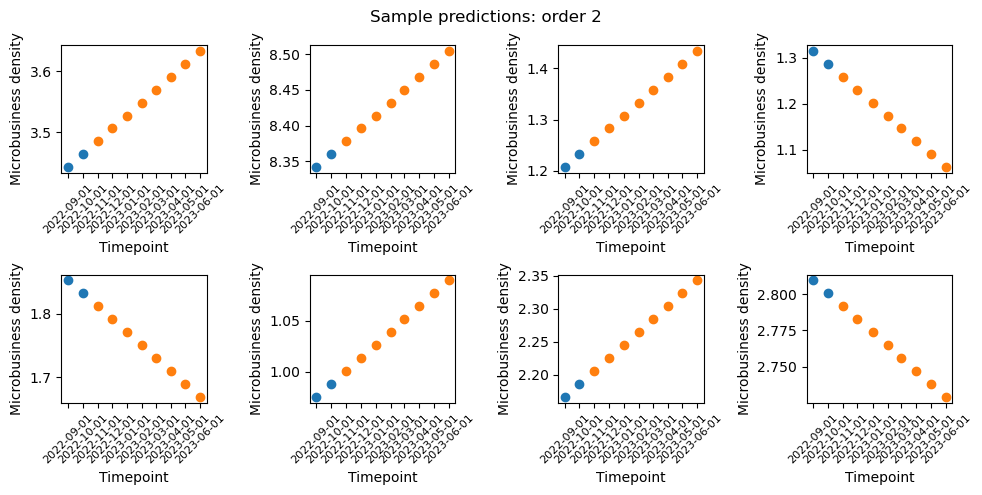


    Sample input data:

                row_id  timepoint_num  cfips          county    state  \
0  1001_2022-08-01              0   1001  Autauga County  Alabama   
1  1001_2022-09-01              1   1001  Autauga County  Alabama   
2  1001_2022-10-01              2   1001  Autauga County  Alabama   
3  1003_2022-08-01              0   1003  Baldwin County  Alabama   
4  1003_2022-09-01              1   1003  Baldwin County  Alabama   

  first_day_of_month  microbusiness_density  active  
0         2022-08-01               3.423852    1455  
1         2022-09-01               3.442677    1463  
2         2022-10-01               3.463856    1472  
3         2022-08-01               8.491150   14545  
4         2022-09-01               8.341701   14289  

    Forecast range: [3, 4, 5, 6, 7, 8, 9, 10]
    


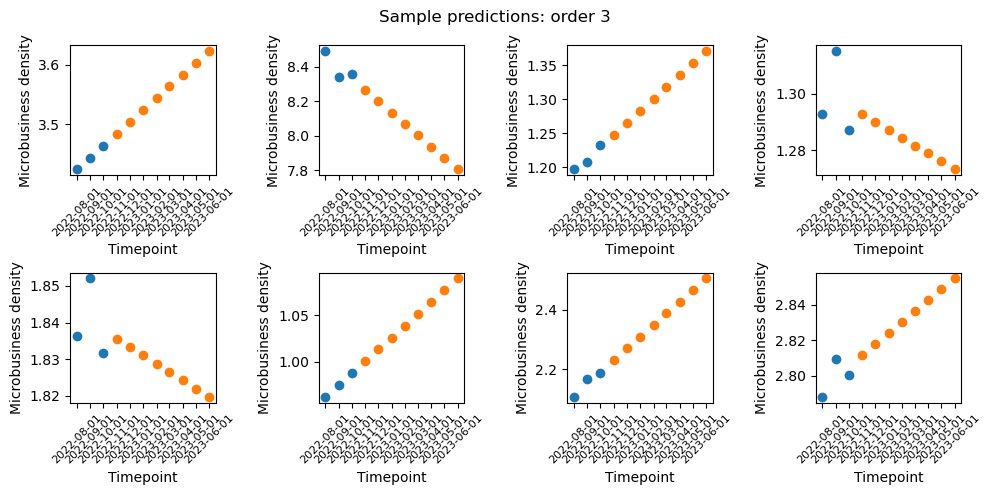


    Sample input data:

                row_id  timepoint_num  cfips          county    state  \
0  1001_2022-07-01              0   1001  Autauga County  Alabama   
1  1001_2022-08-01              1   1001  Autauga County  Alabama   
2  1001_2022-09-01              2   1001  Autauga County  Alabama   
3  1001_2022-10-01              3   1001  Autauga County  Alabama   
4  1003_2022-07-01              0   1003  Baldwin County  Alabama   

  first_day_of_month  microbusiness_density  active  
0         2022-07-01               3.437971    1461  
1         2022-08-01               3.423852    1455  
2         2022-09-01               3.442677    1463  
3         2022-10-01               3.463856    1472  
4         2022-07-01               8.573463   14686  

    Forecast range: [4, 5, 6, 7, 8, 9, 10, 11]
    


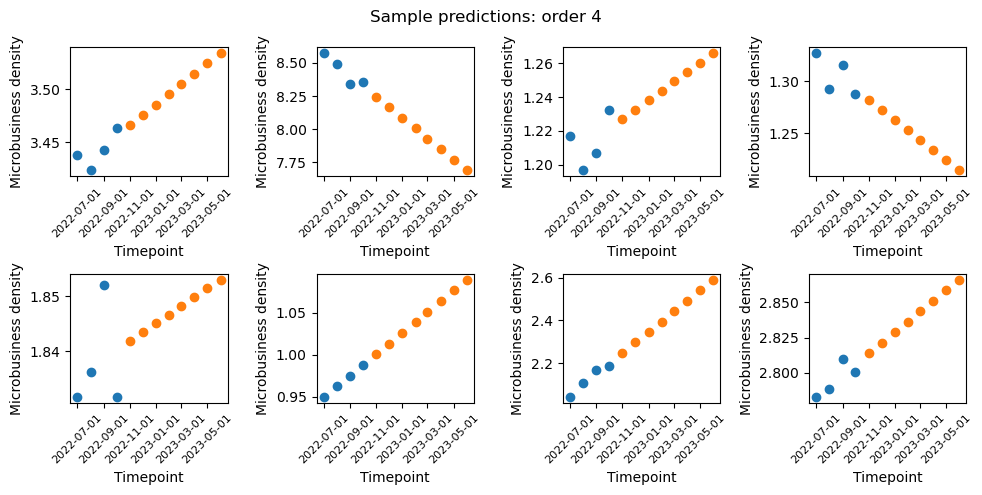


    Sample input data:

                row_id  timepoint_num  cfips          county    state  \
0  1001_2022-06-01              0   1001  Autauga County  Alabama   
1  1001_2022-07-01              1   1001  Autauga County  Alabama   
2  1001_2022-08-01              2   1001  Autauga County  Alabama   
3  1001_2022-09-01              3   1001  Autauga County  Alabama   
4  1001_2022-10-01              4   1001  Autauga County  Alabama   

  first_day_of_month  microbusiness_density  active  
0         2022-06-01               3.346197    1422  
1         2022-07-01               3.437971    1461  
2         2022-08-01               3.423852    1455  
3         2022-09-01               3.442677    1463  
4         2022-10-01               3.463856    1472  

    Forecast range: [5, 6, 7, 8, 9, 10, 11, 12]
    


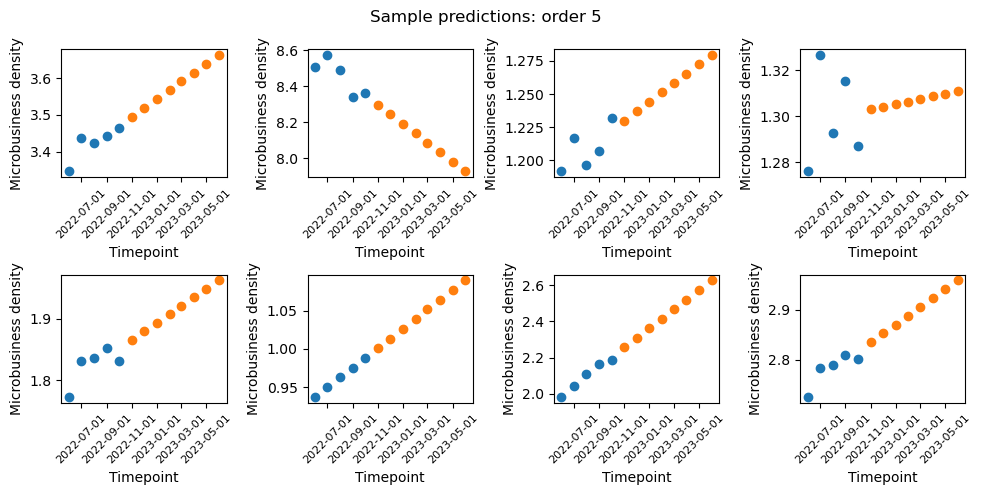


    Sample input data:

                row_id  timepoint_num  cfips          county    state  \
0  1001_2022-05-01              0   1001  Autauga County  Alabama   
1  1001_2022-06-01              1   1001  Autauga County  Alabama   
2  1001_2022-07-01              2   1001  Autauga County  Alabama   
3  1001_2022-08-01              3   1001  Autauga County  Alabama   
4  1001_2022-09-01              4   1001  Autauga County  Alabama   

  first_day_of_month  microbusiness_density  active  
0         2022-05-01               3.313253    1408  
1         2022-06-01               3.346197    1422  
2         2022-07-01               3.437971    1461  
3         2022-08-01               3.423852    1455  
4         2022-09-01               3.442677    1463  

    Forecast range: [6, 7, 8, 9, 10, 11, 12, 13]
    


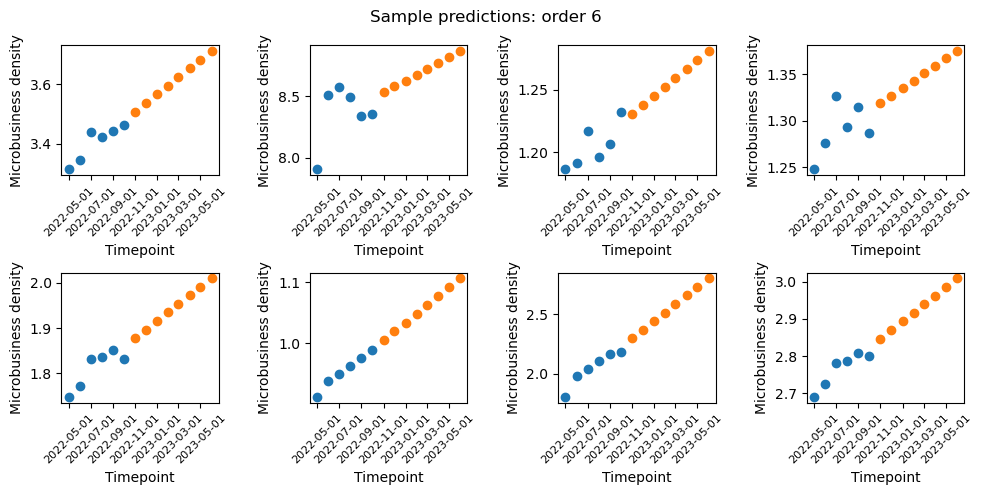

In [7]:
for model_order in model_orders:
    # Get model_order most recent data points for each county
    recent_values_df = data_funcs.build_OLS_data(training_df, model_order)

    # Make list of ints for prediction x based on model order
    xforecast = list(range(model_order, (model_order + 8)))

    # Show sample data for sanity check
    print_values = {
        'sample_input_data': recent_values_df.head(),
        'forecast_range': xforecast
    }

    string = '''
    Sample input data:

    {sample_input_data}

    Forecast range: {forecast_range}
    '''
    print(string.format(**print_values))

    # Holder dict for results
    predictions = {
        'cfips': [],
        'microbusiness_density': []
    }

    # Loop on cfips list and make OLS predictions for each
    for cfips in cfips_list:

        prediction = data_funcs.OLS_prediction(
            recent_values_df[recent_values_df['cfips'] == cfips],
            xinput = 'timepoint_num',
            yinput = 'microbusiness_density',
            xforecast = xforecast
        )

        # Store predictions
        predictions['cfips'].extend([cfips] * 8)
        predictions['microbusiness_density'].extend(prediction)

    # Convert predictions dict to dataframe
    prediction_df = pd.DataFrame(predictions)

    # Concatenate test and prediction dataframes
    submission_df = pd.concat([test_df, prediction_df.drop(['cfips'], axis=1)], axis=1)

    # Plot a few examples
    plt = plot_funcs.n_by_n_prediction_scatterplot(
        input_data = recent_values_df,
        predictions = submission_df,
        x_variable = 'first_day_of_month',
        xlabel = 'Timepoint',
        cfips_list = cfips_list,
        rows = 2,
        columns = 4,
        fig_height = 5,
        main_title = f'Sample predictions: order {model_order}'
    )

    plt.show()

    # Drop un-needed rows from our prediction so the format matches the sample submission
    submission_df.drop(['cfips', 'first_day_of_month'], axis=1, inplace=True)

    # Write csv
    output_file = f'{conf.BENCHMARKING_PATH}/{experiment_date_string}_minimal_OLS_model_order{model_order}_submission.csv'
    submission_df.to_csv(output_file, sep=',', index=False)

Better - at least not totally flat this time! Again, not expecting great success here - just want to get a sense of what is possible with simple, common sense methods. Let's submit it and see what happens.

<a name="results"></a>
### 4. Results

Gosh, this performs much worse that the totally naive model which just predicts no change! I mean, I didn't think this would be a winning solution, but I would have bet that regressing a few points back from the forecast origin would have helped somewhat. I wonder if part of the issue is that it's not November being scored on the public leaderboard. This could explain the loss in accuracy. If January is being scored, it would make sense that our OLS fit, which only saw data up to October would be way off by the time a few months had passed. I can test this pretty easily by submitting a few dummy predictions with the naive model's values for one month at a time and zeros or NANs for the others. Unfortunately, that experiment will have to wait, I am out of submissions for today. Note to self - be more careful with file uploads in the future!

Anyway, here are the results so far:

* OLS model order 2: SMAPE = 1.5904
* OLS model order 3: SMAPE = 1.5563
* OLS model order 4: SMAPE = 1.6055
* OLS model order 5: SMAPE = 1.6528
* OLS model order 6: SMAPE = 1.8835
* Oneshot naive model: SMAPE = 1.0936

Think we need to wait and make sure we know what we are being scored on before we do much else.

**REVISIT** We now know that it is indeed November being scored - see notebook #06. This result suggests a sort of scary thing - the fact that carrying the last value forward handily beats regressing a few points behind it suggests that prior data is not immediately helpful for prediction. We have a few options here:

1. Play with the data - maybe some smoothing would help? 
2. Play with the model - we could try some more 'fancy' tricks, i.e. maybe choose model order by county based on the R<sup>2</sup> or something like that.
3. Change the model - use another approach such as a multiple linear regression or GRU/LSTM.
4. Start adding exogenous data.

I like #2 because it sounds clever and would be easy to add to this notebook. But I think the real plan should be to change the model. We know linear regression is not going to cut it and we need better ways to model the data. This was really the plan all along. We have a naive baseline which OLS regression does not beat so we should move on to more advanced techniques. One caution to be aware of here - in the first round we will still use only the MBD data to establish a baseline for the other modeling techniques we try - and, it may be that with only MBD data, those techniques don't beat the naive baseline. The hope is, that by adding exogenous data sources we can beat the naive model in the end.


<a name="TODO"></a>
### 5. TODO
1. <s>Refactor OLS prediction function to module</s>
2. <s>Update results</s>
3. <s>Triple check regression for continuity of x variable as model order changes</s>